# Project 1

### Topic
I chose to do a more advanced dynamical model of the rocket landing. In addition to the vertical location and velocity, my model also solves for the horizontal location, velocity, and angular orientation and includes drag forces. In addition, the code has been setup with additional layers in the neural network and a batch processing system that can run, theorectically, thousands of randomized initial states at the same time.

### Dynamical Model
The dynamical model and objective model are the following. The controller features to control states, $\mathrm{\ddot{y}\left(t\right),\ddot{x}\left(t\right)}$, which are the vertical and horizontal accelerations respectively. The main engine thrust is the primary control feature for the vertical accelerations, while side thrusters are the primary controls for the horizontal accelerations and angular orientation. The state equations for the dynamic model are as follows,

$\mathrm{x\left(t+1\right)=x\left(t\right)+\dot{x}\left(t\right)\Delta t}$

$\mathrm{\dot{x}\left(t+1\right)=\dot{x}\left(t\right)+\ddot{x}\left(t\right)\Delta t}$

$\mathrm{y\left(t+1\right)=y\left(t\right)+\dot{\dot{y}\left(t\right)\Delta t}}$

$\mathrm{\dot{y}\left(t+1\right)=\dot{y}\left(t\right)+\ddot{y}\left(t\right)\Delta t}$

$\mathrm{\phi\left(t+1\right)=\phi\left(t\right)+\ddot{x}\left(t\right)\Delta t}$

Thus, the stat space of the dynamical system can be expressed as,

$\mathbf{X}\mathrm{\left(t\right)=\begin{bmatrix}x\left(t\right) & \dot{x}\left(t\right) & y\left(t\right) & \dot{y}\left(t\right) & \phi\left(t\right)\end{bmatrix}^{T}}$

The control states are expressed as,

$\mathbf{U}\mathrm{\left(t\right)=\begin{bmatrix}\ddot{y}\left(t\right) & \ddot{x}\left(t\right)\end{bmatrix}^{T}}$

The systems is controlled by a closed-loop controller defined as,

$\mathbf{U}\mathrm{\left(t\right)=\mathit{f_{\theta}}\left(\mathbf{X}\left(t\right)\right)}$

Where, $\mathit{f_{\theta}}$ is the neural network with the parameters $\mathrm{\theta}$ that are found through the optimization process.

### Optimization Model
The optimization model that was used is defined as,

$\mathrm{\underset{\theta}{min}\;\;\left\Vert \mathbf{X}\left(T\right)\right\Vert ^{2}=x\left(T\right)^{2}+\dot{x}\left(T\right)^{2}+y\left(T\right)^{2}+\dot{y}\left(T\right)^{2}+\phi\left(T\right)^{2}}$

$\mathrm{s.t.\;\;\;\;\:x\left(t+1\right)=x\left(t\right)+\dot{x}\left(t\right)\Delta t}$  
$\mathrm{\:\;\;\;\;\;\;\;\;\;\dot{x}\left(t+1\right)=\dot{x}\left(t\right)+\ddot{x}\left(t\right)\Delta t}$  
$\mathrm{\:\;\;\;\;\;\;\;\;\;y\left(t+1\right)=y\left(t\right)+\dot{\dot{y}\left(t\right)\Delta t}}$  
$\mathrm{\:\;\;\;\;\;\;\;\;\;\dot{y}\left(t+1\right)=\dot{y}\left(t\right)+\ddot{y}\left(t\right)\Delta t}$  
$\mathrm{\:\;\;\;\;\;\;\;\;\;\phi\left(t+1\right)=\phi\left(t\right)+\ddot{x}\left(t\right)\Delta t}$  
$\mathbf{U}\mathrm{\left(t\right)=\mathit{f_{\theta}}\left(\mathbf{X}\left(t\right)\right),\:\forall t=1,...,T-1}$

By defining the problem in this way, it becomes an unconstrained optimization problem w.r.t. to $\theta$. The loss/minimization function is defined above to make the perfect/ideal solution have $\mathrm{x\left(T\right)=0,\,\dot{x}\left(T\right)=0,\,y\left(T\right)=0,\,\dot{y}\left(T\right)=0,\,and\,\phi\left(T\right)=0}$. This would correspond to the rocket on the ground with zero horizontal and veritical velocity, and the angular orientation is defined such that $\mathrm{\phi\left(t\right)=0}$ corresponds to the rocket pointing in the positive vertical direction.

[1] loss: 6.113


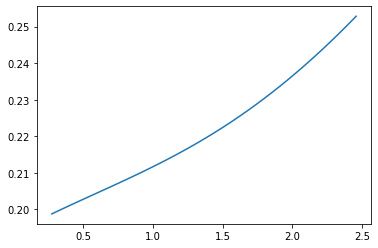

[2] loss: 3.688


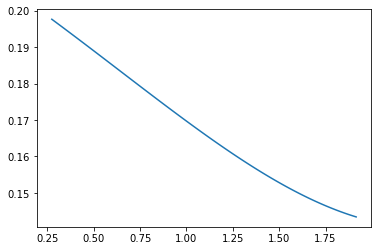

[3] loss: 2.259


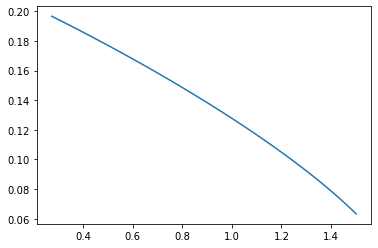

[4] loss: 1.326


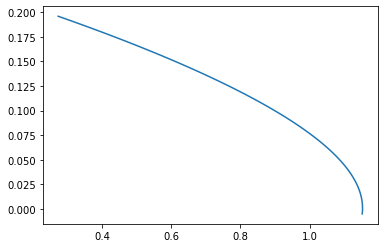

[5] loss: 0.768


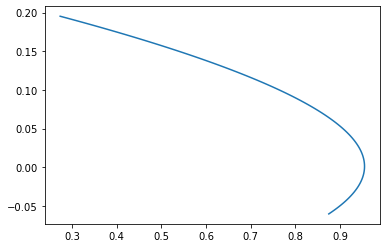

[6] loss: 0.442


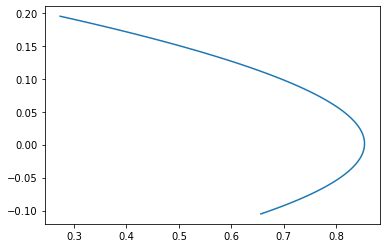

[7] loss: 0.274


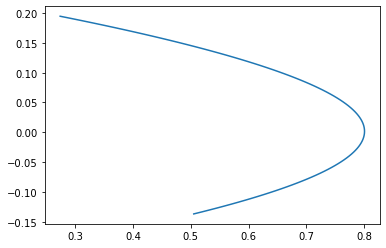

[8] loss: 0.186


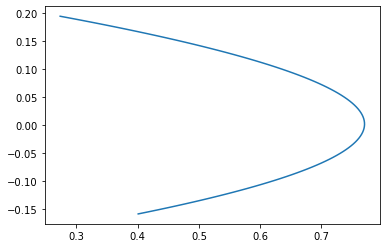

[9] loss: 0.136


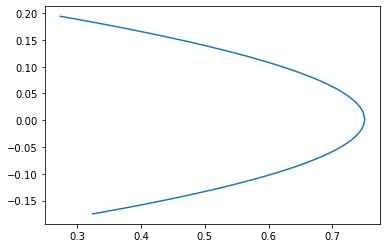

[10] loss: 0.106


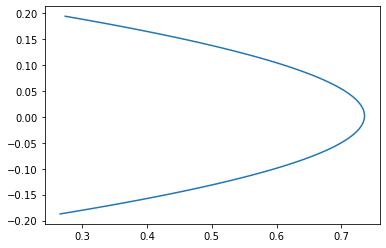

[11] loss: 0.087


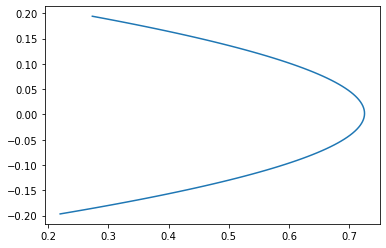

[12] loss: 0.075


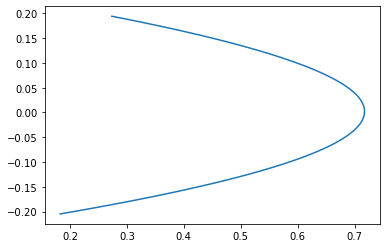

[13] loss: 0.067


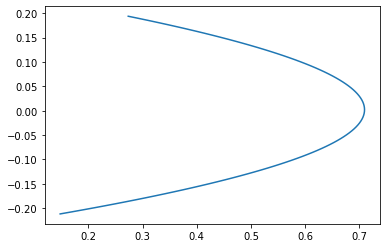

[14] loss: 0.062


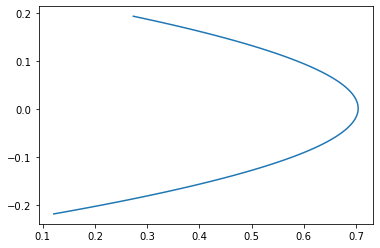

[15] loss: 0.060


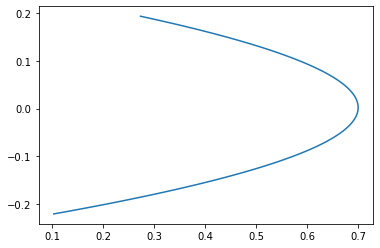

[16] loss: 0.058


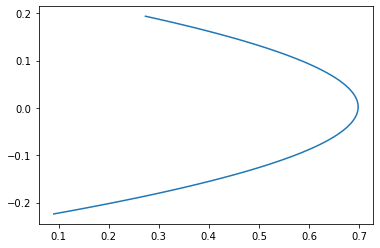

[17] loss: 0.058


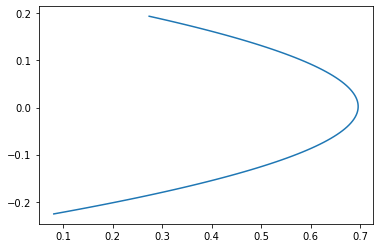

[18] loss: 0.057


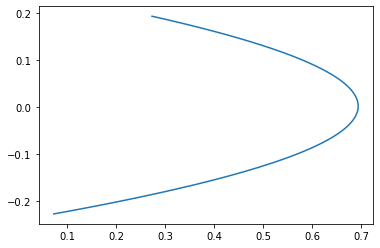

[19] loss: 0.057


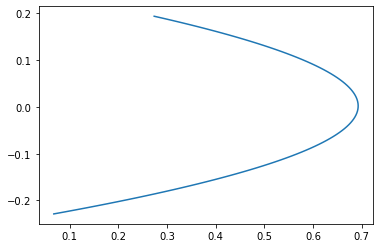

[20] loss: 0.057


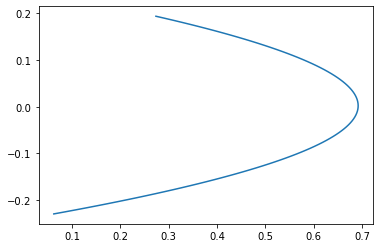

[21] loss: 0.056


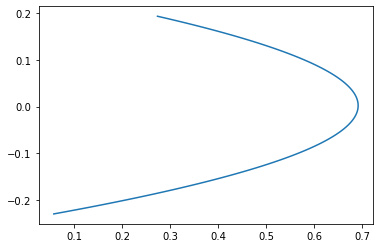

[22] loss: 0.056


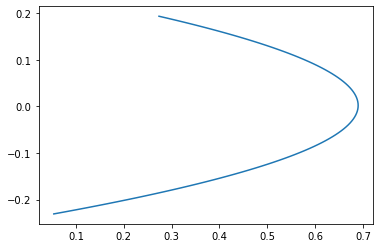

[23] loss: 0.056


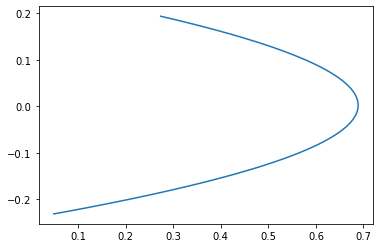

[24] loss: 0.056


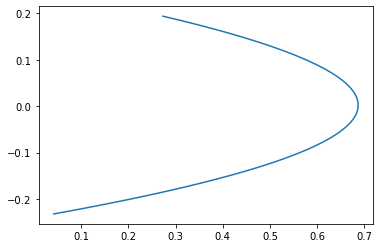

[25] loss: 0.051


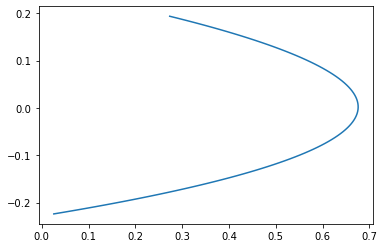

[26] loss: 0.033


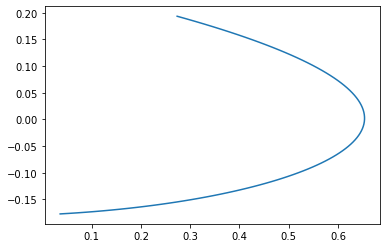

[27] loss: 0.017


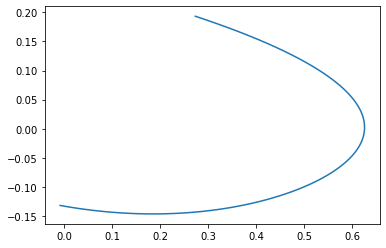

[28] loss: 0.007


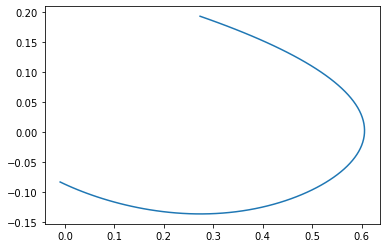

[29] loss: 0.004


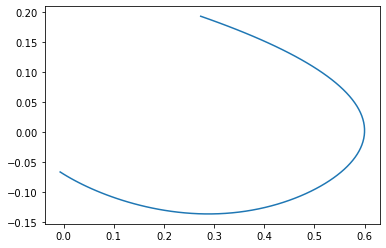

[30] loss: 0.003


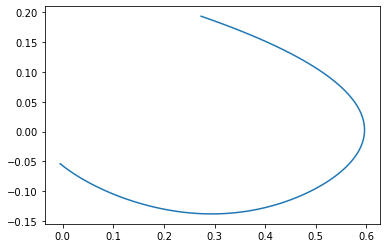

[31] loss: 0.002


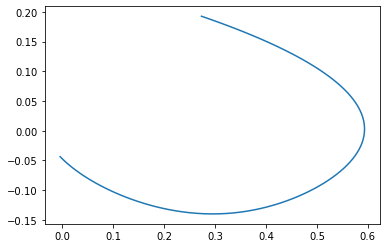

[32] loss: 0.001


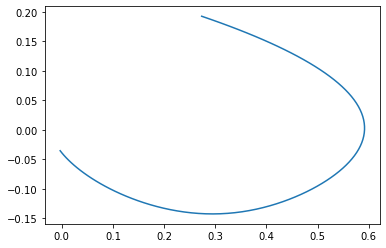

[33] loss: 0.001


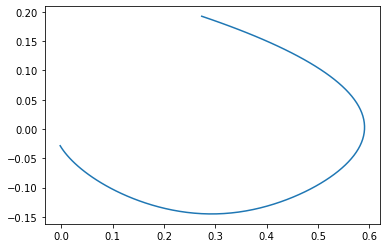

[34] loss: 0.001


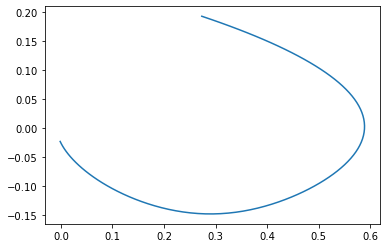

[35] loss: 0.000


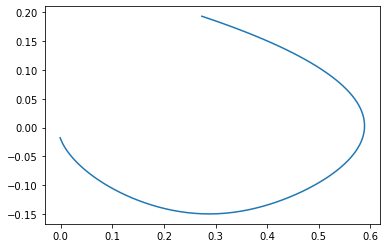

[36] loss: 0.000


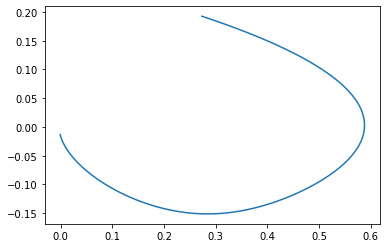

[37] loss: 0.000


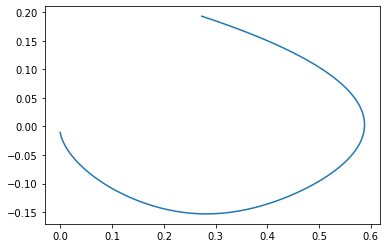

[38] loss: 0.000


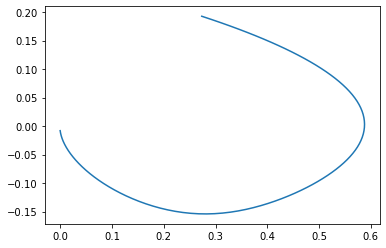

[39] loss: 0.000


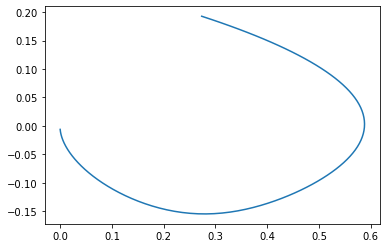

[40] loss: 0.000


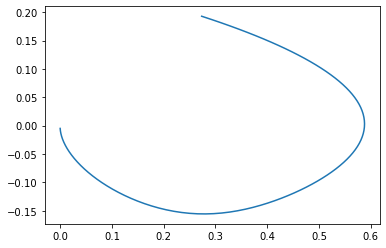

Execution Time: 28.53270983695984 seconds


In [3]:
# MAE 598 Design Optimization - Project # 1
# Benjamin Webb
# 10/21/2022

# Import required libraries
import logging
#import math
import random as rand
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
#from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define global parameters
FRAME_TIME = np.single(0.1)         # time inteval
GRAVITY_ACCEL = np.single(0.12)     # gravitaional acceleration parameter
BOOST_ACCEL = np.single(0.18)       # Trust accelleration parameter

# Define Class for system dynamics
class Dynamics(nn.Module):

	# Initialize class
	def __init__(self):
		super(Dynamics, self).__init__()

	@staticmethod
	def forward(state, action):

		# action: thrust or no thrust

		# Apply gravitational acceleration
		delta_gravity = torch.tensor([0.0, GRAVITY_ACCEL * FRAME_TIME], dtype=torch.float)

		# Apply thrust
		delta_thrust = BOOST_ACCEL * FRAME_TIME * torch.tensor([0.0, -1.0], dtype=torch.float) * action

		# Update velocity
		state = state + delta_thrust + delta_gravity

		# Update state vector
		step_mat = torch.tensor([[1.0, FRAME_TIME],
		                        [0.0, 1.0]], dtype=torch.float)
		state = torch.matmul(step_mat, state)

		return state

# Define Controller Class
class Controller(nn.Module):

	# Initialize class
	def __init__(self, dim_input, dim_hidden, dim_output):
		# dim_input: # of system states
		# dim_output: # of actions
		# dim_hidden: TBD

		super(Controller, self).__init__()
		self.network = nn.Sequential(nn.Linear(dim_input, dim_hidden),
		                             nn.Tanh(), nn.Linear(dim_hidden, dim_output),
		                             nn.Sigmoid())

	# define Controller forward method
	def forward(self, state):
		action = self.network(state)
		return action

# Define Simulation Class
class Simulation(nn.Module):

	# Initialize Class
	def __init__(self, controller, dynamics, T):
		super(Simulation, self).__init__()
		self.state = self.intialize_state()
		self.controller = controller
		self.dynamics = dynamics
		self.T = T
		self.action_trajectory = []
		self.state_trajectory = []

	# Define Simulation class forward method
	def forward(self, state):
		self.action_trajectory = []
		self.state_trajectory = []
		for _ in range(self.T):
			action = self.controller.forward(state)
			state = self.dynamics.forward(state, action)
			self.action_trajectory.append(action)
			self.state_trajectory.append(state)

		return self.error(state)

	@staticmethod
	def intialize_state():
		state = np.array([rand.gauss(mu=0.5, sigma=0.25), rand.gauss(mu=0.5, sigma=0.25)],
		                 dtype=np.single)

		return torch.tensor(data=state, dtype=torch.float, requires_grad=False)

	# Define Simulation class error, will need to be updated for increased state variables
	@staticmethod
	def error(state):
		return state[0]**2 + state[1]**2

# Define Optimizer class. Currently, using LBFGS
class Optimize:

	# Initialize class
	def __init__(self, simulation):
		super(Optimize, self).__init__()
		self.simulation = simulation
		self.parameters = simulation.controller.parameters()
		self.optimizer = optim.LBFGS(self.parameters, lr=0.01)      # Current learning rate at 0.01

	# Define Optmize class step function
	def step(self):
		# Define Closure function so gradient can be calculated multiple times
		def closure():
			loss = self.simulation(self.simulation.state)
			self.optimizer.zero_grad()
			loss.backward()

			return loss

		# Possible reccursive operation
		self.optimizer.step(closure)

		return closure()

	# Define Optimize class train function
	def train(self, epochs):
		for epoch in range(epochs):
			loss = self.step()
			print('[%d] loss: %.3f' % (epoch + 1, loss))
			self.visualize()                                # Will update later

	# Define Optimize class visulize function, will be updated later
	def visualize(self):
		data = np.zeros((self.simulation.T, 2), dtype=np.single)
		for i in range(self.simulation.T):
			temp = self.simulation.state_trajectory[i].detach()
			data[i, :] = temp.numpy()

		x = data[:, 0]
		y = data[:, 1]
		plt.plot(x, y)
		plt.show()

# Define main program script
if __name__ == '__main__':

	# Begin timer
	start_time = time.time()

	# Initial test to ensure code is working
	T = 100             # number of time steps
	dim_input = 2       # number of state-space variables, currently 2, will be expanded to 4
	dim_hidden = 6      # depth of neurnal network
	dim_output = 1      # number of actions, currently 1, will be expanded to 2

	d = Dynamics()                                      # Created Dynamics class object
	c = Controller(dim_input, dim_hidden, dim_output)   # Created Controller class object
	s = Simulation(controller=c, dynamics=d, T=T)       # Created Simulation class object
	o = Optimize(simulation=s)                          # Created Optimizer Class object
	o.train(epochs=40)                                  # Test code

	# End timer
	end_time = time.time()

	# Print program execution time
	total_time = end_time - start_time
	print('Execution Time:', total_time, 'seconds')
